In [34]:
from compute import Var, Par, Model, adda, addf, ureg, Evaluable, buildidpvars
from compute import RefNode, SolverNode, addsolver, geteqs
from operators import merge
from anytree import Node
from constants import μ, R, Q, k, c, G, H_int, ρ_int
from representations import render_tree, digraph_repr, drawfull, tree_incidence
from notation import graphs_from_incidence, make_acyclic, solvers_bottom_up, generate_execution, default_sequence
from datastructures import notation_from_tree
import numpy as np
import sympy as sp
import networkx as nx
from sympy.utilities.lambdify import implemented_function
import matplotlib.pyplot as plt

# Parameters

In [2]:
#EN = Var('EN', 10) #
D_r = Par('D_r', 5.3, 'm')
L = Par('L', 9.77)
T_s = Par('T_s', 135, 'K')
B = Par('B', 8, 'bit')
N = Par('N', 2e3, '')
eta = Par('eta', 0.55)
l_v = Par('l_v', 500, 'nm')
f = Par('f', 2.2, 'GHz')
rho_T = Par('rho_T', 500e3, 'kg*m')
rho_P = Par('rho_P', 0.002e-3, 'kg/J')
P_l = Par('P_l', 12, 'W')
m_c = Par('m_c', 0.2, 'kg')
C_D = Par('C_D', 2.2)
I_sp = Par('Isp', 70, 's')
w_W = Par('w_W', 1000, 'rad/s')
c_W = Par('c_W', 1)
rho_M = Par('rho_M', 11.4)
rho_P2 = Par('rho_P2', 9/0.1)
M_B = Par('M_B', 7.96e15)
kp = Par('kp', 0.0002)

In [16]:
model = Model()
m = RefNode(name='/', ref=model)

### 1. Orbit

In [17]:
h = Var('h', 400, 'km') #
a = adda(m, 'a', h + R, unit='km')
T = adda(m, 'T', 2*np.pi*(a**3/μ)**0.5, unit='min')
g = adda(m, 'g', 1/np.pi*sp.acos(R/a), unit='')
d = adda(m, 'd', g+0.5)
r = adda(m, 'r', (h**2+2*R*h)**0.5)

In [18]:
orbit = addsolver(m, geteqs(m, [a,T,g,d,r]), [], name='orbit')

### 2. Power

In [19]:
eta_A = Par('eta_A', 0.3)
rho_A = Par('rho_A', 10, 'kg/m^2') #
#ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
A = Var('A', 0.05, unit='m^2')
m_A = adda(m, 'm_A', rho_A*A)
P_c = adda(m, 'P_c', d*A*Q*eta_A, unit='W')
P_T = adda(m, 'P_T', P_c-P_l) #hack
E_b = adda(m, 'E_b', P_c*T/d)
rho_b = Par('rho_b', 0.002, 'kg/kJ')
m_b = adda(m, 'm_b', rho_b*E_b, unit='kg')
#E_b, m_b = E_bi[bat], m_bi[bat]

In [20]:
power = addsolver(m, geteqs(m, [m_A, P_c, P_T, E_b, m_b]), [], name='power')

### 3. Payload

In [21]:
X_r = Var('X_r', 5, 'm')
D_p = adda(m, 'D_p', 1.22*l_v*h/X_r)
D = adda(m, 'D', 2*np.pi*R*B*N/X_r, unit='MB')
rho_p = Par('rho_p', 2, 'kg/m^1.5') 
#D_p, m_p = D_pi[payload], m_pi[payload]
m_p = adda(m, 'm_p', rho_p*D_p**1.5, unit='kg')

In [22]:
payload = addsolver(m, geteqs(m, [D_p, D, m_p]), [], name='payload')

### 4. Comms

In [23]:
dBtoLinear = lambda db: 10**(db/10)
b = adda(m, 'b', D/T, unit='MB/s')
λ_c = adda(m, 'l_c', c/f, unit='cm')
G_T = Par('G_T', dBtoLinear(16.5), '')
D_T = adda(m, 'D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
rho_T = Par('rho_T', 0.2, 'kg/m^1.5')
m_T = adda(m, 'm_T', rho_T*D_T**1.5, unit='kg')
#m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
G_r = adda(m, 'G_r', eta*(np.pi*D_r/λ_c)**2)
EN = adda(m, 'EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, unit='')

In [24]:
comms = addsolver(m, geteqs(m, [b, λ_c, D_T, m_T, G_r, EN]), [], name='payload')

### 5. Mass and struct

In [25]:
mt = Var('mt', unit='kg')
eta_S = Par('eta_S', 0.2)
m_s = adda(m, 'm_s', eta_S*mt)
adda(m, mt, m_T+m_p+m_b+m_A+m_s)

In [26]:
struct = addsolver(m, geteqs(m, [m_s]), [], name='struct')
mass = addsolver(m, geteqs(m, [mt]), [], name='mass')

### 6. Propulsion

In [27]:
H = implemented_function(sp.Function('H'), H_int)
rho = implemented_function(sp.Function('rho'),  ρ_int)

In [28]:
L_min = Var('L_min', 5, 'yr')
m_pr = Var('m_pr', 0.5, unit='kg')
Hval = adda(m, 'H_val', H(h*1e3), unit='m', forceunit=True)
rhoval= adda(m, 'rho_val', rho(h*1e3), unit='kg/m**3', forceunit=True)
Ln = adda(m, 'L_n', Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T, unit='yr')
Lp = adda(m, 'L_p', m_pr*I_sp*G*a/(0.5*C_D*A*rhoval*μ), unit='yr')
Lt = adda(m, 'L_t', Ln+Lp, unit='yr')

In [29]:
prop = addsolver(m, geteqs(m, [Hval, rhoval, Ln, Lp, Lt]), [], name='prop')

In [30]:
render_tree(m)

/               
├── orbit       
│   ├── f_{0}   
│   ├── f_{1}   
│   ├── f_{2}   
│   ├── f_{3}   
│   └── f_{4}   
├── power       
│   ├── f_{5}   
│   ├── f_{6}   
│   ├── f_{7}   
│   ├── f_{8}   
│   └── f_{9}   
├── payload     
│   ├── f_{10}  
│   ├── f_{11}  
│   └── f_{12}  
├── payload     
│   ├── f_{13}  
│   ├── f_{14}  
│   ├── f_{15}  
│   ├── f_{16}  
│   ├── f_{17}  
│   └── f_{18}  
├── struct      
│   └── f_{19}  
├── mass        
│   └── f_{20}  
└── prop        
    ├── f_{21}  
    ├── f_{22}  
    ├── f_{23}  
    ├── f_{24}  
    └── f_{25}  


In [36]:
eqs, eqv, dout, dins = model.data_structures()

In [33]:
sequence_m = default_sequence(m)

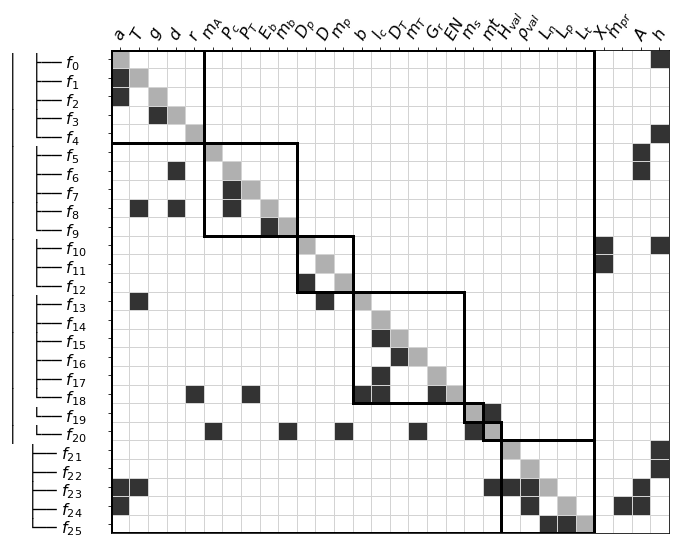

In [37]:
fig, ax = tree_incidence(m, eqv, model.outset, sequence_m, figsize=(10,10));
plt.sca(ax)
plt.savefig('figures/sat.png', dpi=600, bbox_inches='tight')

### Tree & Graph

In [18]:
G, graphs = graphs_from_incidence(m, from_root=True)

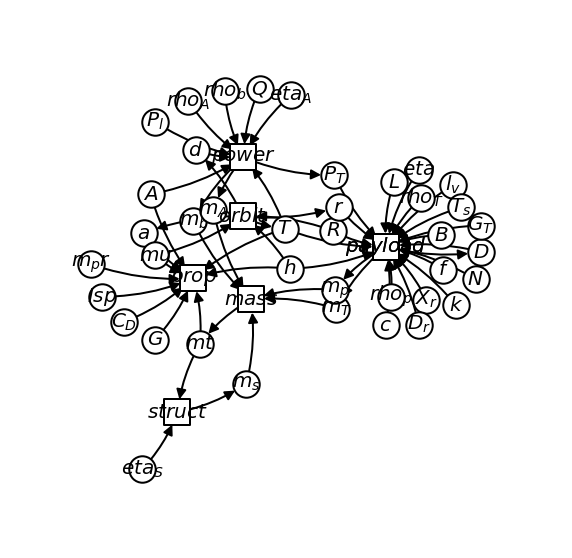

In [19]:
drawfull(graphs[m], model.eqs, figsize=(10,10))

In [20]:
m2 = make_acyclic(m, graphs)

In [21]:
render_tree(m2, display_type=True)

/               
├── orbit, SOLVER
│   ├── f_0, INTER
│   ├── f_4, INTER
│   ├── f_1, INTER
│   ├── f_2, INTER
│   └── f_3, INTER
├── power, SOLVER
│   ├── f_5, INTER
│   ├── f_6, INTER
│   ├── f_7, INTER
│   ├── f_8, INTER
│   └── f_9, INTER
├── payload, SOLVER
│   ├── f_10, INTER
│   ├── f_11, INTER
│   └── f_12, INTER
├── payload, SOLVER
│   ├── f_13, INTER
│   ├── f_14, INTER
│   ├── f_15, INTER
│   ├── f_17, INTER
│   ├── f_16, INTER
│   └── f_18, INTER
├── prop, SOLVER
│   ├── f_21, INTER
│   ├── f_22, INTER
│   ├── f_23, INTER
│   ├── f_24, INTER
│   └── f_25, INTER
└── ., SOLVER   
    ├── f_19, END
    └── f_20, END


In [29]:
notation = notation_from_tree(m2, model.outset)

# Execution order

In [33]:
execorder = generate_execution([notation])
execorder

[('exp', 0, a, 'f_0'),
 ('exp', 0, r, 'f_4'),
 ('exp', 0, T, 'f_1'),
 ('exp', 0, g, 'f_2'),
 ('exp', 0, d, 'f_3'),
 ('exp', 0, m_A, 'f_5'),
 ('exp', 0, P_c, 'f_6'),
 ('exp', 0, P_T, 'f_7'),
 ('exp', 0, E_b, 'f_8'),
 ('exp', 0, m_b, 'f_9'),
 ('exp', 0, D_p, 'f_10'),
 ('exp', 0, D, 'f_11'),
 ('exp', 0, m_p, 'f_12'),
 ('exp', 0, b, 'f_13'),
 ('exp', 0, l_c, 'f_14'),
 ('exp', 0, D_T, 'f_15'),
 ('exp', 0, G_r, 'f_17'),
 ('exp', 0, m_T, 'f_16'),
 ('exp', 0, EN, 'f_18'),
 ('exp', 0, H_val, 'f_21'),
 ('exp', 0, rho_val, 'f_22'),
 ('exp', 0, L_n, 'f_23'),
 ('exp', 0, L_p, 'f_24'),
 ('exp', 0, L_t, 'f_25'),
 ('solver', 0, 1, [m_s, mt], ['f_19', 'f_20'])]